In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 7)

inspections = pd.read_csv('data/inspections.csv')

# Quantitative Empirical Distributions

---


When an attribute is quantitative and continuous, calculating the empirical distribution by simply counting the occurrence of each value does not work. The reason for this is that values of continuous attributes are often *close together*, but *rarely identical*. The distribution of values of a quantitative attribute are better described by first grouping together nearby values, then calculating the proportion of the whole made up by each group. These groups are called *bins*.

**Example:** Treating quantitative variables as categorical is rarely a good idea for understanding the distribution of data. For example, plotting the distribution of health inspection scores as categorical data results in a noisy plot that ignores the relative distances between scores.

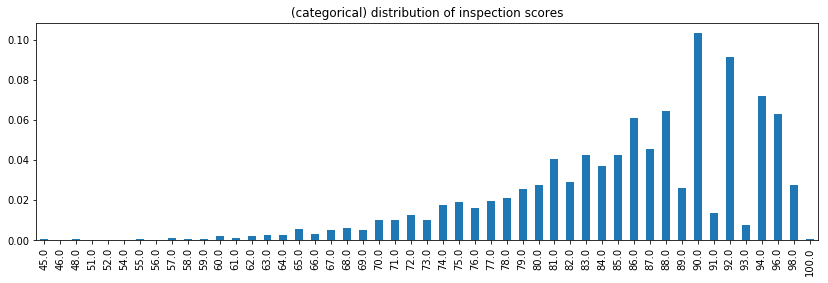

In [4]:
(
    inspections['inspection_score']
    .value_counts(normalize=True)
    .sort_index()
    .plot(kind='bar', figsize=(14,4), title='(categorical) distribution of inspection scores')
);

*Remark:* Notice there is information in treating the score as a categorical variables:
* Among the higher scores, even numbered inspection scores are much more likely.
* Certain high scores don't occur, such as 95, 97, and 99. Is this an artifact of how the score is computed? Or did the data recording process result in missing or incorrect data? 

**Definition:** A *probability density* of an empirical distribution at a value $x$ is the proportion of the observations per unit  that occur near $x$. The appropriate value of 'near' corresponds to choosing a bin size for grouping data. The bin size should make sense when interpreting it in terms of the data generating process (e.g. what is the precision and scale of the measurements at hand? How much noise is inherent to the data generating process?).

For more an elementary, more detailed account, see the visualization chapter of [inferential thinking](https://www.inferentialthinking.com/chapters/07/2/Visualizing_Numerical_Distributions.html).

### Computing quantitative distributions with `np.histogram`

Quantitative distributions can be calculated with the help of `np.histogram`. Given an array of numbers `nums`, `np.histogram(nums, density=True)` returns an array of densities of elements in each bins and an array of bin edges.

A few notes on the keyword arguments of `np.histogram`:
* The array of bin edges is one element larger than the array of densities (and the number of bins).
* By default, the histogram uses 10 equally sized bins, spanning the range of the input data.
* Specifying a different number of bins (via an integer) results in equally sized bins.
* Non-equally sized bins are specified by passing a list of end-points.
* Passing `density=False` (the default) results in an array of counts, instead of densities.

**Example:** The empirical distribution of restaurant health inspection scores is computed using `np.histogram`, then plotting a bar chart.

In [5]:
densities, bins = np.histogram(inspections['inspection_score'], density=True)

In [6]:
densities

array([0.00028443, 0.00031437, 0.0011876 , 0.00300394, 0.00906172,
       0.0151195 , 0.03392156, 0.0454533 , 0.05697006, 0.01650171])

In [7]:
bins

array([ 45. ,  50.5,  56. ,  61.5,  67. ,  72.5,  78. ,  83.5,  89. ,
        94.5, 100. ])

In [17]:
binned = pd.Series(densities, bins[:-1])
binned

45.0    0.000284
50.5    0.000314
56.0    0.001188
          ...   
83.5    0.045453
89.0    0.056970
94.5    0.016502
Length: 10, dtype: float64

The binned data can then be plotted as a bar chart, using a few specialized keyword to make the plot appropriate as a histogram:
* the `width` keyword fits the bars to the width of the bins,
* the `align` keyword aligns each bar to the left endpoint labeling each bin.

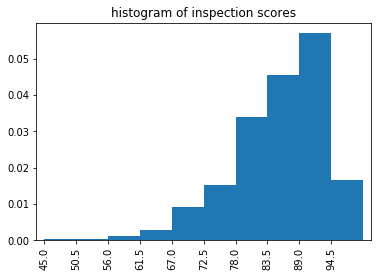

In [19]:
title='histogram of inspection scores'
binned.plot(kind='bar', align='edge', width=1, title=title);

The histogram can be plotted directly, using the `plot` method. However this method has two disadvantages:
1. it works for plotting only, and doesn't provide the user with the binned data itself, and
1. it slower and more memory intensive than `np.histogram`. 

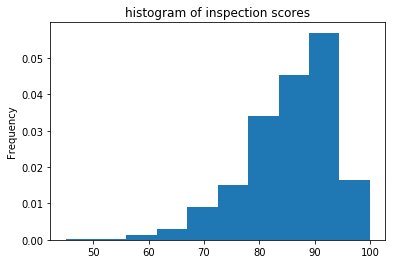

In [20]:
inspections['inspection_score'].plot(kind='hist', bins=10, density=True, title='histogram of inspection scores');

Similarly, Pandas also provides a kernel density estimate, which is a smoothed histogram of the observed data. While very slow to plot, it avoids the need to choose an 'appropriate' bin size:

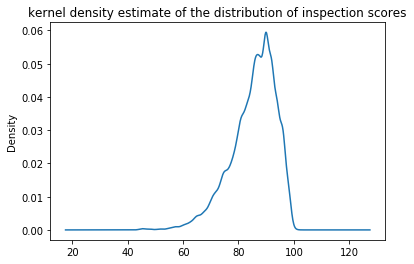

In [22]:
inspections['inspection_score'].plot(
    kind='kde', 
    title='kernel density estimate of the distribution of inspection scores'
);

**Example:** One can also specify different conditions on the binning of the data. For example, to specify equal bins by passing an integer to the `bins` keyword:

In [85]:
densities, bins = np.histogram(inspections['inspection_score'], bins=5, density=True)

In [86]:
pd.Series(densities, bins[:-1])

45.0    0.000299
56.0    0.002096
67.0    0.012091
78.0    0.039687
89.0    0.036736
dtype: float64

To specify the bin endpoints explicitly, one may pass a list to `bins`. For example, to use bins with endpoints at numbers divisible by 10:

In [23]:
densities, bins = np.histogram(inspections['inspection_score'], bins=range(40,101,10), density=True)

In [24]:
pd.Series(densities, bins[1:])

50     0.000156
60     0.000486
70     0.003669
80     0.016286
90     0.041587
100    0.037816
dtype: float64

### Cumulative Distribution Functions

Cumulative distribution functions describe quantitative distributions more naturally than their empirical distributions. Describing the density of a quantitative distribution near a single value requires *binning* the data into bins of an 'appropriate size' for the scenario. However, since the CDF of a quantitative distribution describes the cumulative proportion of values, it doesn't require assumptions on bin size.

**Definition:** The cumulative distribution function $F(x)$ at a value $x$ is defined as the probability an event at most of size $x$ is likely to occur.

**Definition:** The empirical cumulative distribution function of an attribute $X$ at a value $x$ is the proportion of values in $X$ that are at most $x$.

If `X` is a Series containing the attribute in question. The empirical cumulative distribution function `cdf_X` is defined as:

In [1]:
def cdf_X(x):
    return (X < x).mean()

*Remark:* Since the observations of any dataset is finite, the definition of a categorical CDF and a quantitative empirical CDF are the same -- as such, they can also be computed identically. However, for large datasets, quantitative columns have a many distinct values, making the computation of "all the values" of the CDF (as in the categorical case) computationally expensive. Thus, treating the empirical CDF as a function, rather than a dataframe, makes more sense.